Prior to running the first cell, you will have to open a terminal and pip install both seaborn and scikit-learn.

The user should install the requirements packages from requirements.txt file.

# Imports

*   Import the necessary libraries for python functions.

In [1]:
from operator import itemgetter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import math as math

from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import KFold
from pdb import pm # post-mortem debugger (run this function when you encounter an error)

# BMA Function Definitions

*   The key idea with BMA is to combine different models to improve prediction performance.
*   BMA works by sampling different weights and then evaluating the performance of the combined model using those weights.
* The key metric for evaluation is RMSE, which is defined as $RMSE = \sqrt{\frac{1}{N}\sum_{i=1}^N (y_i-\hat{y}_i)^2}$, where $y_i$ is the $i$th observation and $\hat{y}_i=\sum_{m=1}^M w_m\hat{y}_{im}$ is the weighted average of the $M$ models' prediction values.
* By repeatedly sampling weights, one can obtain an estimate of the optimal weights according to $RMSE$.
* The best set of weights $x_{\text{best}}$ as well as the posterior set of weights $x_{\text{posterior}}$ are provided to the user as:
$$(weights_{\text{BMA,optimal}}, weights_{\text{BMA,posterior}})$$.

# Calculating independence for BMA (for lines #51-53)

* More recently, weighting based on model independence has been an additional criterion to consider alongside model skill. This consideration of model independence has emerged due to models having common bases of model structure, parameterizations, and associated programming code, all of which can result in a lack of independence between climate models. Here, independence information is estimated in the post-processing of the model weights, and we determine model independence information using the posterior distribution of the BMA weights. To quantify independence here, we take the sum of the correlation matrix of the posterior samples and subtract 1 from this. This results in a negative independence score for models that have independent posterior samples and a positive independence score for models that have dependent posterior samples.

In [2]:
# def get_bma_predictions(y_obs, predictions_dict, n_sample=10000, confidence=0.9):
def get_bma_predictions(y_obs, models, n_sample=10000, confidence=0.9):
    """Calculates the optimal weights and predictions using the BMA procedure described above.

    # Parameters
      y_obs : np.ndarray of shape (nobs,)
        Observed response values.
      predictions_dict : dictionary with model name as key and np.ndarray of shape (nobs,) as value
        Predictions from two or more models.
      n_sample : int
        Number of times weights are sampled for the algorithm.
      confidence : float between 0 and 1
        Confidence level for weights and predicted values.

    # Returns
      y_BMA_best : np.ndarray of shape (nobs,)
        BMA predictions from model with optimal weights.
      y_BMA_posterior : np.ndarray of shape (nobs, n_posterior)
        BMA predictions from set of weights that are within confidence level.
      x_best : np.ndarray of shape (len(predictions_dict),)
        Optimal weights from BMA procedure.
      x_posterior : np.ndarray of shape (n_posterior, len(predictions_dict))
        Set of weights that are within confidence level.
    """
    n_posterior = int(n_sample * (1 - confidence))
    n_models = models.shape[1]
    x = np.random.uniform(0, 1, (n_sample, n_models)) ** (1 / 2)
    x_pars = x / np.sum(x, axis=1, keepdims=True)

    y_BMA = np.zeros((len(y_obs), n_sample))
    RMSE_BMA = np.empty(n_sample)
  
    if models.shape[0] == x_pars.shape[1]:
        y_BMA = np.dot(x_pars,models)        
    else: 
        y_BMA = np.dot(x_pars,np.transpose(models))
            
    for i in range(n_sample):
        RMSE_BMA[i] = np.sqrt(np.sum((y_BMA[i,:] - y_obs) ** 2) / len(y_obs))

    RMSE_best = np.min(RMSE_BMA)
    id_best = RMSE_BMA.argmin()

    # using ids with lowest (best) RMSEs, pick out the corresponding weights
    best_ids = np.argsort(RMSE_BMA)[:n_posterior]

    x_best = x_pars[id_best, :] # This grabs the optimal (absolute best) sets of weights
    y_BMA_best = y_BMA[id_best,:] # This grabs the optimal (absolute best) outputs
    x_posterior = x_pars[best_ids] # This grabs the posterior (top N samples) sets of weights

    y_BMA_posterior = np.zeros((len(y_obs), n_posterior))
    
    if models.shape[0] == x_posterior.shape[1]:
        y_BMA_posterior = np.dot(x_posterior,models)        
    else: 
        y_BMA_posterior = np.dot(x_posterior,np.transpose(models))
        
    corr_BMA_samples = np.corrcoef(x_posterior,rowvar=False) ;
    sum_corr_BMA_samples = np.sum(corr_BMA_samples,axis=1);
    I_BMA_samples = sum_corr_BMA_samples*-1;
    
    return y_BMA_best, y_BMA_posterior, x_best , x_posterior, I_BMA_samples  # [ optimal outputs, posterior output, optimal weights, posterior weights ]

# # Example for random problem
# n_samples = 10,000
# n_posterior = 1,000
# n_models = 20
# n_obs = 2314

# all_samples -> 10,000 x 20
# observation data -> 2314 x 1

# size( y_BMA_best, y_BMA_posterior, x_best , x_posterior )
# y_BMA_best -> 2314 x 1
# y_BMA_posterior -> 2314 x 1,000
# x_best -> 20 x 1
# x_posterior -> 20 x 1,000


# # Example for Projectile motion problem
# n_samples = 10,000
# n_posterior = 1,000
# n_models = 3
# n_obs = 7

# all_samples ->  10,000 x 3
# observation data -> 7 x 1

# size( y_BMA_best, y_BMA_posterior, x_best , x_posterior )
# y_BMA_best ->  7 x 1
# y_BMA_posterior ->  7 x 1,000
# x_best ->  3 x 1
# x_posterior ->  3 x 1,000

## AIC Definition

AIC can also be used to weight different models. AIC captures some notion of model fit, so it makes sense to use this information to weight higher the models that fit the data the best. The formula for AIC is $AIC = -2 \hat{L} + 2 p$, where $\hat{L}$ is the the estimated likelihood from the model and $p$ is the number of parameters in the model.

When used for weighting, a typical approach is to use the weight

$$
weights_{AIC} = \frac{e^{-1/2 \cdot AIC_m}}{\sum_{m=1}^M e^{-1/2 \cdot AIC_m}}
$$

for the $m$th model. This way, the weights add to one, and can be used to calculate a weighted average of the predictions of each model, just like with BMA: $\hat{y}_i=\sum_{m=1}^M w_m\hat{y}_{im}$.

The difference between this approach (AIC) and BMA is that BMA samples and tests the performance of different weights to see which weights are optimal. Whereas AIC simply uses the fit of each model to determine the weights.

In [3]:
def AIC(observation, models, number_parameters):
    """
    Calculates the Akaike Information Criterion (AIC) for a Bayesian model.

    # Parameters
        observation : np.ndarray of shape (nobs,)
            Observed response values.
        models : np.ndarray of shape (nobs,)
            Predicted response values from the model.
        number_parameters : int
            Number of parameters in the model.

    # Returns
        aic : float
            Akaike Information Criterion value.
        weights : Optimal weights from AIC procedure.

    """
    n_models = models.shape[1]
    aic = np.empty(n_models)
    for i in range(n_models):
        #weights[i] = AIC(observation,models[:, i], number_parameters[i])
    
        residuals = observation - models[:, i]
    
        SSE = np.sum(residuals ** 2)

        number_observations = len(observation)

        sigma_squared = SSE / number_observations

        log_likelihood = -0.5 * number_observations * np.log(2 * np.pi * sigma_squared) - 0.5 * SSE / sigma_squared

        aic[i] = -2 * log_likelihood + 2 * number_parameters[i]
        
    # Assuming you have a list of aic values
    aic_values = np.exp(-aic*(1/2))

    # Calculate weights using math.exp()
    weights = [aic_values / np.sum(aic_values)]
    
    return weights


## The Sanderson Approach for both skill and independence

* Models differ in their skill to simulate observations, and there is an inherent lack of independence between models.
*There are weighting strategies in the literature for use with climate model ensembles, which consider both model performance skill as well as the interdependency of models that arises from common development and calibration practices of the models.
*These strategies are used to estimate a model average from several ensemble members that were simulated from dependent models of varying skill.
*In this context, we use the RMSE as a representation of skill, however users can create and use different options for this metric.
*This score is used as an input to develop our skill metric weights. We follow a similar recipe as Sanderson et al. (2015, 2017) and estimate model weights using
the skill metrics with:

$$
w_{m,Skill(i)} = A * e^{ - ( \frac{ \delta_{i,(obs)}}{Dq} )^2 }
$$

* where A is a normalizing constant such that the sum of all the weights is equal to 1, δi(obs) is the “Median Skill” score for each model, and Dq is the radius of model quality, which determines the degree to which models with poor skill should be down‐weighted. A very small value of Dq will allocate a large fraction of weight to the single best‐performing model. Equally, as Dq approaches infinity, the model average will include more information from the non‐skill weighted models. For our study, we use a value of Dq = 0.9
* The independence scores for each model can be calculated using the intermodel distances, which are a function of the RMSE between each of the models. The intermodel distance matrix is constructed with the RMSE values, and the similarity scores, S(δi,j), are then calculated for each pair of models i and j using this distance matrix. This score is calculated as follows:

$$ 
S(\delta_{i,j}) = e^{ - ( \frac{ \delta_{i,j}}{Du} )^2 }
$$

* where δi j are the RMSE values from the intermodel distance matrix and Du is the radius of similarity (Sanderson et al., 2015), which is a free parameter that determines the distance scale over which models should be considered similar and thus down‐weighted for co‐dependence. We choose a value of Du = 0.5, which is shown in Sanderson et al. (2015), to be an appropriate value. In theory, two identical models will produce a similarity score of S(δi,j) = 1, and this score approaches 0 as the distance between the models grows infinitely.

* The independence scores, wu(i), are calculated using the similarity scores for each model in the following manner:

$$ 
w_{u}(i) = \Biggl\{1+\sum_{j\neq i}^n S(\delta_{i,j}) \Biggr\}^{-1}
$$

* where n is the total number of models. Finally, the equation used to combine the uniqueness and skill information to create the Sanderson set of model weights is:

$$ 
weights_{Sanderson}(i) = A * w_{m,Skill(i)} * w_{u}(i)
$$

* where A is a normalizing constant such that the sum of all the weights is equal to 1.

In [4]:
## The Sanderson Approach for only skill

def calculate_rmse(observation, models):
    n_models = models.shape[1]
    rmse_models = np.empty(n_models)
    for i in range(n_models):
        rmse_models[i] = np.sqrt(np.sum((models[:, i] - observation) ** 2) / len(observation))
    return rmse_models

def calculate_normalized_rmse(rmse_models):
    rmse_norm = 1+(rmse_models - np.mean(rmse_models)) / np.mean(rmse_models)
    return rmse_norm

def calculate_skill_score(rmse_norm, d_q):
    skill_score = np.exp(-np.power(rmse_norm / d_q, 2))
    return skill_score

def calculate_skill_weights(skill_score):
    skill_weights = skill_score / np.sum(skill_score)
    return skill_weights

def sanderson_skill(observation, models, d_q):
    rmse_models = calculate_rmse(observation, models)
    rmse_norm = calculate_normalized_rmse(rmse_models)
    skill_score = calculate_skill_score(rmse_norm, d_q)
    skill_weights = calculate_skill_weights(skill_score)
    
    return skill_weights

def sanderson_independence(models, d_u):
    # outer for loop
    n_models_2 = models.shape[1]
    delta_ij =  np.zeros((n_models_2,n_models_2))
    S_ij =  np.zeros((n_models_2,n_models_2))        
    R_u =  np.zeros((1,n_models_2))
    w_u =  np.zeros((1,n_models_2))
    for i in range(n_models_2):
        for j in range(n_models_2):
             delta_ij[i,j] = np.sqrt(np.sum((models[:,i] - models[:,j]) ** 2) / models.shape[0])
             S_ij[i,j] = np.exp(-np.power(delta_ij[i,j]/ d_u, 2))
             R_u[0,i] = 1 + np.sum(S_ij[i,:])
             w_u[0,i] = R_u[0,i]**-1
                            
    independence_score = w_u
    return independence_score

def sanderson_weights(skill_weights,independence_score):
    weights_score = skill_weights * independence_score
    weights = weights_score/ np.sum(weights_score)
    
    return weights
    

The provided code calculates and publishes the shape of a prediction matrix, and then calls the sanderson_skill function with the observed values and the prediction matrix to determine skill weights. The remaining lines are commented out and most likely contain further calculations relating to RMSE, normalized RMSE, and skill score, but their usefulness and outputs cannot be identified without additional implementation details.

In [5]:
## The code is related to the first example.


# Given arrays
T = np.array([0, 1, 2, 3, 4, 5, 6])
y = np.array([100, 110, 115, 110, 90, 60, 20])

print(y.shape)

# Calculation of M1, M2, M3
M1 = 100 + 10*T + 1/2*-9.8*T**2
M2 = 100 + 8*T + 1/2*-9.8*T**2 - 3
M3 = 100 + 20*T + 1/2*-9.8*T**2 + T/np.sqrt(T + 1)

# Dictionary of predictions
prediction_matrix = np.array([M1 , M2 , M3])
prediction_matrix = np.transpose(prediction_matrix)
print(prediction_matrix.shape)

(7,)
(7, 3)


In [6]:
## This code below takes average of the three models.

# Average of M1, M2, M3
M_avg = np.mean(np.array([M1, M2, M3]), axis=0)

print(M_avg)
print(M_avg.shape)

[ 99.         107.00236893 105.11823351  93.4         71.86295146
  40.51374715  -0.64407105]
(7,)


In [7]:
# Now test the Sanderson_skill function with this problem
skill_weights = sanderson_skill(observation=y, models=prediction_matrix, d_q=0.9)
print(skill_weights)

[0.28038498 0.0829099  0.63670512]


In [8]:
## The code prints out the different RMSE's of the three different model in example 1.

#models = np.transpose(prediction_matrix)
models = prediction_matrix
print(models.shape)
observation=y
d_q=0.9

n_models = models.shape[1]
rmse_models = np.empty(n_models)

for i in range(n_models):
        rmse_models[i] = np.sqrt(np.sum((models[:, i] - observation) ** 2) / len(observation))

print(rmse_models)


(7, 3)
[23.92174743 33.66590051 13.94740387]


# Plotting Predictions

In [9]:
## This goes into the Toolbox -- post-processing

# plotting function
def plot_lines(x, y_dict, xlabel, ylabel, confidence_data=None):
  """Plots the predictions of various data from the input dictionary and can
  additionally plot confidence data associated with one of the model predictions.

  # Parameters
    x : np.ndarray of shape (nobs,)
      Observed covariate values.
    y_dict : dictionary with model name: np.ndarray of shape (nobs,) as items
      Predictions or observations from two or more models.
    xlabel : string
      Label for x-axis.
    ylabel : string
      Label for y-axis.
    confidence_data : np.ndarray of shape (nobs, n_posterior)
      Predictions that are within a certain confidence level.

  # Example
  ```
  import numpy as np

  T = np.array([0, 1, 2, 3, 4, 5, 6])
  y = np.array([100, 110, 115, 110, 90, 60, 20])

  M1 = 100 + 10*T + 1/2*-9.8*T**2
  M2 = 100 + 8*T + 1/2*-9.8*T**2 - 3

  # Dictionary of predictions
  predictions_dict = {'NOAA': M1, 'NASA': M2}

  # Average of M1, M2
  M_avg = np.mean(np.array([M1, M2]), axis=0)

  y_BMA_best, y_BMA_posterior, x_best , x_posterior = get_bma_predictions(y_obs=y, predictions_dict=predictions_dict, n_sample=1000, confidence=0.9)

  y_dict = {'Data': y, **predictions_dict, 'EnsMean': M_avg, 'BMA': y_BMA_best}

  plot_lines(
    x=T, y_dict=y_dict, xlabel='Time [sec]', ylabel='Elevation [m]',
    confidence_data=y_BMA_posterior
  )
  ```
  """
  plt.figure(figsize=(6, 4), dpi=200)
  marker_styles = ['r*', 'b:+', 'b:^', 'b:o', 'k:*', 'k:o']
  for (label, y), marker_style in zip(y_dict.items(), marker_styles):
    if label == 'Data':
      markersize = 20
    else:
      markersize = 10
    plt.plot(x, y, marker_style, linewidth=2, markersize=markersize)

  plt.legend(y_dict.keys())
  plt.ylabel(ylabel)
  plt.xlabel(xlabel)
  plt.xticks(fontsize=10)
  plt.yticks(fontsize=10)
  title = 'Model Predictions'

  if confidence_data is not None:
    plot_df = pd.DataFrame({
        'x': np.kron(np.arange(0, confidence_data.shape[0]), np.ones(confidence_data.shape[1])),
        'y': confidence_data.reshape(-1)
    })
    ax = sns.lineplot(
      x='x', y='y', data=plot_df, estimator=np.median
    )
    ax.fill_between(
      x,
      plot_df.groupby('x').quantile(0).squeeze(),
      plot_df.groupby('x').quantile(1).squeeze(),
      alpha=0.3
    )
    title += ' with BMA Confidence Interval'

  plt.title(title)
  plt.show()


def plot_prediction_boxplots(y_dict, orient='h',x_label='value'):
  """Plots the predictions of various data from the input dictionary and can
  additionally plot confidence data associated with one of the model predictions.

  # Parameters
    y_dict : dictionary with model name: np.ndarray of shape (nobs,) as items
      Predictions from two or more models.
    orient : str, either 'h' or 'v'
      The orientation of the boxplots.
    x_label : str, defaults to value
        The label for the predictions.

  # Example
  ```
  import numpy as np

  T = np.array([0, 1, 2, 3, 4, 5, 6])
  M1 = 100 + 10*T + 1/2*-9.8*T**2
  M2 = 100 + 8*T + 1/2*-9.8*T**2 - 3

  # Dictionary of predictions
  predictions_dict = {'NOAA': M1, 'NASA': M2}

  plot_prediction_boxplots(predictions_dict, orient='h')
  ```
  """
  plot_df = pd.DataFrame.from_dict(y_dict).stack().reset_index()
  plot_df.columns = ['observation', 'model', x_label]
  if orient == 'h':
    sns.boxplot(data=plot_df, x=x_label, y='model', color='white')
  else:
    sns.boxplot(data=plot_df, x='model', y=x_label, color='white')
  plt.show()

Stacking



* Stacking is a model ensembling technique that combines multiple individual models by training a meta-model on their predictions, aiming to improve overall predictive performance.
* Use in Bayesian Model Averaging (BMA): Stacking can be used in Bayesian Model Averaging (BMA) by incorporating the predictions of individual models as input to the BMA framework, allowing for the aggregation of different model's outputs to obtain more accurate and robust predictions.
* Relevance: Stacking is relevant in BMA as it helps overcome the limitations of using a single model by leveraging the strengths of multiple models. By combining the predictions from diverse models, stacking can potentially reduce bias, increase model stability, and improve overall predictive accuracy in BMA.

In [10]:
## Stacking code w/ the formulas

import numpy as np
from sklearn.linear_model import LinearRegression


def stack_BMA(predictors, y):
    """Gets BMA predictions based on stacking method.

    # Parameters
      predictors : Dictionary of predictors for each model.
        The keys are model names, and the values are the predictor matrices.
      y : Observed response data, e.g. S_T

    # Returns
      weights : optimal weights calculated with stacking
      stacking_predictions : np.ndarray with shape (nobs,)
        The predictions calculated from the weights of stacking.
    """

    n_models = len(predictors)
    n_samples = len(y)

    # Initialize matrix for model predictions
    model_predictions = np.zeros((n_samples, n_models))

    # Generate predictions from each individual model
    for i, (model_name, X) in enumerate(predictors.items()):
        # Fit model
        model = LinearRegression().fit(X, y)
        # Get predictions
        y_pred = model.predict(X)
        # Store predictions
        model_predictions[:, i] = y_pred

    # Calculate optimal weights using linear regression
    weights = np.linalg.lstsq(model_predictions, y, rcond=None)[0]

    # Calculate stacking predictions
    stacking_predictions = np.dot(model_predictions, weights)

    return weights, stacking_predictions # [ optimal weights, optimal outputs ]


In [11]:
# Stacking code for example 1 - This will go to under the first example
def generate_example_data_matrix(model_name, T):
  """Generates an example data matrix for the fictional NOAA, NASA, and DOE
  models for projectile motion.

  # Parameters
    model_name : string
      Name of the model, can either be 'NOAA', 'NASA', or 'DOE'
    T : np.ndarray of shape (nobs,)
      Input times, e.g. [0, 1, 2, 3, ...]

  # Returns
    X.T : np.ndarray of shape (nobs, 3)
  """
  n_observations = len(T)
  if model_name == 'NOAA':
    # three featuers, similar to nasa
    X = np.stack([
        np.ones(n_observations),
        T,
        T**2
    ])
  elif model_name == 'NASA':
    # three featuers
    X = np.stack([
        np.ones(n_observations),
        T,
        T**2
    ])
  elif model_name == 'DOE':
    # four featuers
    X = np.stack([
        np.ones(n_observations),
        T,
        T**2,
        T / np.sqrt(T + 1)
    ])
  else:
    raise ValueError('Model name not recognized.')
  return X.T


def fit_example_model(model_name, X, y):
  """Fits a fictional NOAA, NASA, or DOE model for projectile motion
  using the input data.

  # Parameters
    model_name : str
      Name of the model, can either be 'NOAA', 'NASA', or 'DOE'
    X : np.ndarray of shape (nobs, 3)
      Features, generated by `generate_data_matrix`
    y : np.ndarray of shape (nobs,)
      Observed response data, e.g. S_T

  # Returns
    model : fitted sklearn.linear_model.LinearRegression object
      Fitted model.

  """
  model = LinearRegression()
  if model_name == 'NASA':
    model_fit = model.fit(X, y)
    model = lambda x: model_fit.predict(x) - 3
  else:
    model_fit = model.fit(X, y)
    model = lambda x: model_fit.predict(x)
  return model


def stack_MSE(w, y, y_pred):
    """Helper function for `stack_BMA`. Calculates MSE for the input data
    and weights.

    # Parameters
      w : np.ndarray of shape (n_models,)
        Weights of the models.
      y : np.ndarray of shape (nobs,)
        Observed response data, e.g. S_T
      y_pred : np.ndarray of shape (nobs, n_models)
        Predictions from each model stacked horizontally into a matrix.

    # Returns
      A float with the MSE value.
    """
    return np.mean((y - y_pred @ w)**2)


def stack_BMA(predictors, y, model_fitting_functions):
    """Gets BMA predictions based on stacking method.

    # Parameters
      predictors : Dictionary with model name: predictor as items,
      with length n_models.
        Dictionary of predictors for each model.
      y : np.ndarray of shape (nobs,)
        Observed response data, e.g. S_T
      model_fitting_functions : iterable of functions with length n_models
        Functions used to fit each individual model.

    # Returns
      bma_predictions : np.ndarray with shape (nobs,)
        The predictions calculated from the weights of stacking.
    """
    # leave-one-out process requires n folds
    n_folds = len(y)
    kfold = KFold(n_splits=n_folds, shuffle=False)
    # initialize
    loo_model_predictions = np.zeros((n_folds, len(model_fitting_functions)))

    # Generate predictions from each individual models
    for i, (model_name, model_fitting_function) in enumerate(
      model_fitting_functions.items()
    ):
        # generate data
        X = predictors[model_name]
        # get predictions from each fold
        for j, (train_idx, val_idx) in enumerate(kfold.split(X)):
            # get train and validation data, should have n - 1
            # and 1 observations respectively
            X_train, y_train = X[train_idx], y[train_idx]
            X_val, y_val = X[val_idx], y[val_idx]
            # fit model
            model = model_fitting_function(X_train, y_train)
            # get predictions from fold and store
            y_pred = model(X_val)
            loo_model_predictions[j, i] = y_pred
    # with leave-one-out predictions, choose the best set of weights
    # based on MSE
    model_names = model_fitting_functions.keys()
    constraint = lambda w: w.sum() - 1
    w_hat = minimize(
        # objective function
        fun=stack_MSE,
        # starting set of weights (equal across models)
        x0=np.ones(len(model_names)) / len(model_names),
        # other args for `stack_MSE`
        args=(y, loo_model_predictions),
        # constrain weights to sum to 1
        constraints=[{'type':'eq', 'fun': constraint}],
        # weights must be non-negative
        bounds=[(0, None)] * len(model_names)
    ).x
    # get BMA predictions from optimal weights
    bma_predictions = loo_model_predictions @ w_hat
    return bma_predictions

Equilibrium Climate Sensitivity (ECS)



*   Equilibrium Climate Sensitivity (ECS) is an important statistic in climate research that estimates the Earth's climate system's long-term response to increased greenhouse gas concentrations. It shows the increase in world average surface temperature caused by doubling atmospheric CO2 concentrations once the climate system reaches equilibrium.
*   ECS is important in the context of developing a model weighting toolset. The toolbox intends to evaluate and combine various climate models in order to improve the accuracy of climate projections. Users can assign weights to individual models depending on their ability to accurately mimic ECS by integrating ECS as a parameter or function inside the toolbox. Models that closely match observed ECS values might be given more weight, showing their accuracy in forecasting future climate changes. This technique ensures that the weighing process takes into account the essential component of climate sensitivity, allowing for more robust and informed decision-making in climate research and policy.

In [12]:
## Calculates Model Weights for Equilibrium Climate Sensitivity (ECS)

def calculate_ecs(models, weights):
    # Create an empty list to store the calculated ECS values for each model
    ecs_values = []

    # Iterate through each model and its corresponding weight
    for model, weight in zip(models, weights):
        # Perform calculations specific to each model
        ecs_model = model.calculate_ecs()  # Calculate ECS for the current model

        # Multiply ECS by the model weight
        weighted_ecs = ecs_model * weight

        # Add the weighted ECS to the list
        ecs_values.append(weighted_ecs)

    # Sum up the weighted ECS values to obtain the total ECS
    total_ecs = sum(ecs_values)

    # Return the total ECS
    return total_ecs

In [13]:
#skippping a few line here to go to the first example

In [14]:
#skippping a few line here to go to the first example

In [15]:
## This is an example. Should be its own script that runs the toolbox

# Given arrays
T = np.array([0, 1, 2, 3, 4, 5, 6])
y = np.array([100, 110, 115, 110, 90, 60, 20])

# Calculation of M1, M2, M3
M1 = 100 + 10*T + 1/2*-9.8*T**2
M2 = 100 + 8*T + 1/2*-9.8*T**2 - 3
M3 = 100 + 20*T + 1/2*-9.8*T**2 + T/np.sqrt(T + 1)

# Dictionary of predictions
predictions_dict = {'NOAA': M1, 'NASA': M2, 'DOE': M3}
prediction_matrix = np.array([M1 , M2 , M3])
prediction_matrix = np.transpose(prediction_matrix)
# print(prediction_matrix)

# Average of M1, M2, M3
M_avg = np.mean(np.array([M1, M2, M3]), axis=0)

# Function call to get_bma_predictions
y_BMA_best, y_BMA_posterior, x_best , x_posterior, I_BMA_samples = get_bma_predictions(y_obs=y, models=prediction_matrix, n_sample=1000, confidence=0.9)
print(x_best)

# Now test the AIC function with this problem
weights = AIC(observation=y, models=prediction_matrix, number_parameters = [3,3,4])
print(weights)

# Now test the Sanderson_skill function with this problem
skill_weights = sanderson_skill(observation=y, models=prediction_matrix, d_q=0.9)
print(skill_weights)

# Now test the sanderson_independence function with this problem
independence_score = sanderson_independence(models=prediction_matrix, d_u=0.5)
print(independence_score)

# Now test the sanderson_weights function with this problem
weights = sanderson_weights(skill_weights=skill_weights, independence_score=independence_score)
print(weights)



[0.22257988 0.09936365 0.67805647]
[array([0.05829696, 0.00533169, 0.93637135])]
[0.28038498 0.0829099  0.63670512]
[[0.5 0.5 0.5]]
[[0.28038498 0.0829099  0.63670512]]


In [16]:
print(np.array([M1, M2, M3]))

[[100.         105.1        100.4         85.9         61.6
   27.5        -16.4       ]
 [ 97.         100.1         93.4         76.9         50.6
   14.5        -31.4       ]
 [100.         115.80710678 121.55470054 117.4        103.38885438
   79.54124145  45.86778684]]


In [17]:
print(weights)

[[0.28038498 0.0829099  0.63670512]]


In [18]:
print(y.shape)
print(prediction_matrix.shape)

(7,)
(7, 3)


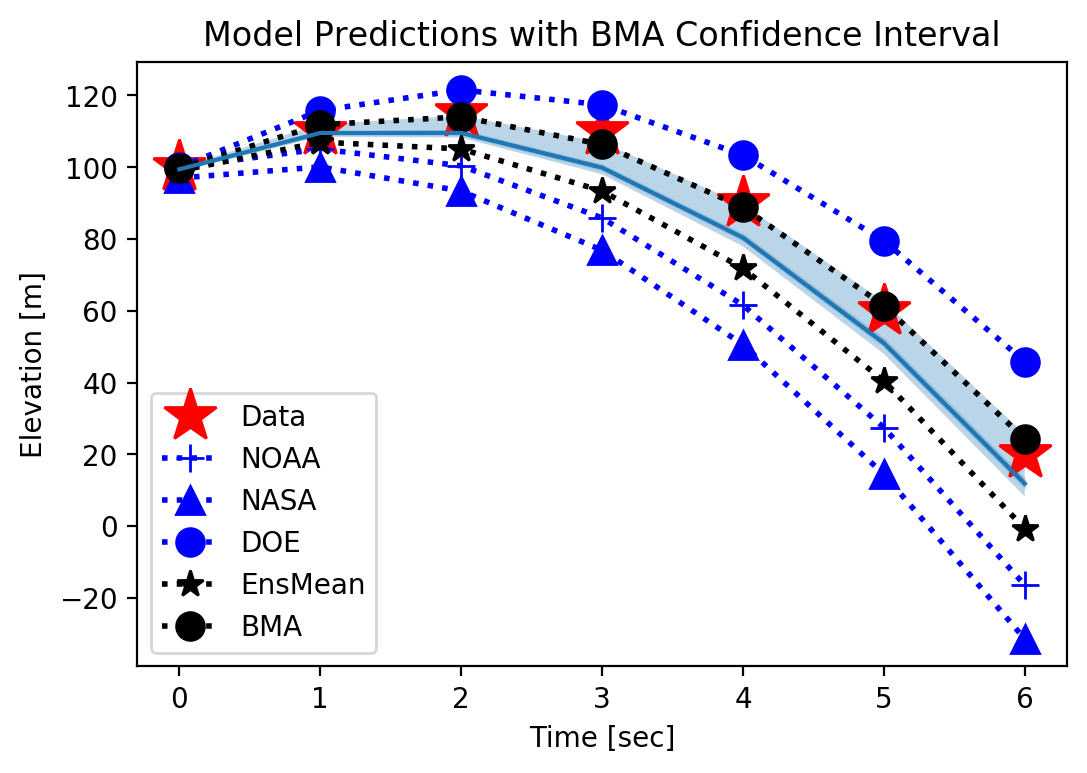

In [19]:
## This is an example. Should be its own script that uses post-processing

y_dict = {
  'Data': y,
  **predictions_dict,
  'EnsMean': M_avg,
  'BMA': y_BMA_best
}
plot_lines(
  x=T, y_dict=y_dict, xlabel='Time [sec]', ylabel='Elevation [m]',
  confidence_data=np.transpose(y_BMA_posterior)
)

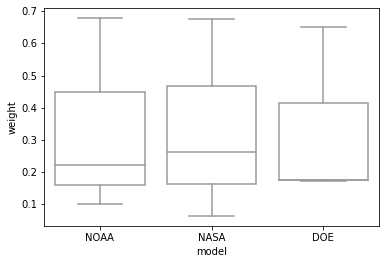

In [20]:
## This is an example. Should be its own script that uses post-processing (ran into a issue here)

import numpy as np
import matplotlib.pyplot as plt

def plot_weights(model_names, weights_posterior, orient='h'):
    # Create a dictionary of model names and weights
    d = dict(zip(model_names, weights_posterior))
    plot_df = pd.DataFrame.from_dict(d).stack().reset_index()
    plot_df.columns = ['observation', 'model', 'weight']

    if orient == 'h':
        sns.boxplot(data=plot_df, x='weight', y='model', color='white')
    else:
        sns.boxplot(data=plot_df, x='model', y='weight', color='white')

    plt.show()

# Assuming you have the BMA posterior weights stored in the variable BMA_posterior
# Call the function to plot the weights
model_names = predictions_dict.keys()
plot_weights(model_names, x_posterior, orient='v')

<BarContainer object of 3 artists>

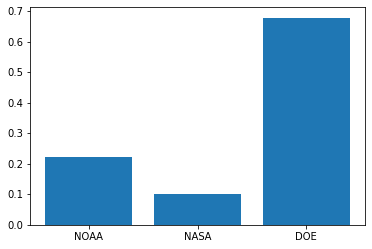

In [21]:
plt.bar(*[model_names, x_best])

In [22]:
print(x_best)

[0.22257988 0.09936365 0.67805647]


In [23]:
x_best.sum()

1.0

In [24]:
model_names = ['NOAA', 'DOE', 'NASA']
predictors = {
    model_name: generate_example_data_matrix(model_name, T)
    for model_name in model_names
}
model_fitting_functions = {
    model_name: lambda X, y: fit_example_model(
      model_name=model_name, X=X, y=y
    )
    for model_name in model_names
}

In [25]:
bma_predictions = stack_BMA(
  predictors=predictors,
  y=y,
  model_fitting_functions=model_fitting_functions
)

In [26]:
bma_predictions

array([ 90.5       , 110.5       , 113.        , 104.14285714,
        86.5       ,  57.5       ,  18.        ])

In [27]:
#skippping a few line here to go to the second example

In [28]:
#skippping a few line here to go to the second example

In [29]:
#Row 1-100

In [30]:
## This is a whole new example. Should be its own script that runs the toolbox

#Place to upload csv files
# importing pandas module
import pandas as pd
# reading the csv file
csvDataframe = pd.read_csv('tasmax_moddat1(smaller).csv', error_bad_lines=False)

In [31]:
csvDataframe.head()

,ACCESS-CM2,ACCESS-ESM1-5,CanESM5,CMCC-ESM2,EC-Earth3-CC,FGOALS-g3,GFDL-CM4,GFDL-ESM4,INM-CM4-8,INM-CM5-0,...,KACE-1-0-G,KIOST-ESM,MPI-ESM1-2-HR,MPI-ESM1-2-LR,MRI-ESM2-0,NESM3,NorESM2-LM,NorESM2-MM,TaiESM1,OBS1
0,294.102945,297.806059,296.534305,295.213958,295.465349,294.651894,294.442440,294.221047,295.182774,295.161337,...,294.844400,296.530124,296.095287,296.408525,294.998292,293.694737,296.223636,295.718332,296.249549,294.795714
1,294.129950,297.872713,296.554070,295.260822,295.514219,294.665576,294.506369,294.274118,295.191235,295.160050,...,294.866279,296.551327,296.175094,296.426855,295.037294,293.700550,296.252843,295.748984,296.266640,294.813088
2,294.156955,297.939366,296.573834,295.307685,295.563090,294.679257,294.570298,294.327189,295.199696,295.158762,...,294.888159,296.572529,296.254901,296.445185,295.074794,293.706364,296.282050,295.779635,296.283730,294.833921
3,294.183960,298.006020,296.593599,295.354549,295.611960,294.692939,294.634227,294.380261,295.208156,295.157474,...,294.910039,296.593732,296.334709,296.463516,295.110791,293.712177,296.311256,295.810287,296.300821,294.858212
4,294.210964,298.072674,296.613364,295.401412,295.647850,294.706620,294.698155,294.433332,295.216617,295.156186,...,294.931918,296.614935,296.414516,296.481846,295.146789,293.717991,296.340463,295.840939,296.317911,294.882502


In [32]:
csvDataframe.columns

Index(['ACCESS-CM2', 'ACCESS-ESM1-5', 'CanESM5', 'CMCC-ESM2', 'EC-Earth3-CC',
       'FGOALS-g3', 'GFDL-CM4', 'GFDL-ESM4', 'INM-CM4-8', 'INM-CM5-0',
       'IPSL-CM6A-LR', 'KACE-1-0-G', 'KIOST-ESM', 'MPI-ESM1-2-HR',
       'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3', 'NorESM2-LM', 'NorESM2-MM',
       'TaiESM1', 'OBS1'],
      dtype='object')

In [33]:
csvDataframe.describe()

,ACCESS-CM2,ACCESS-ESM1-5,CanESM5,CMCC-ESM2,EC-Earth3-CC,FGOALS-g3,GFDL-CM4,GFDL-ESM4,INM-CM4-8,INM-CM5-0,...,KACE-1-0-G,KIOST-ESM,MPI-ESM1-2-HR,MPI-ESM1-2-LR,MRI-ESM2-0,NESM3,NorESM2-LM,NorESM2-MM,TaiESM1,OBS1
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,...,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,294.043265,298.073554,296.449509,295.355197,295.698928,294.512931,294.604844,294.307464,295.139597,295.058446,...,294.802149,296.307470,296.474020,296.340176,295.029104,293.538866,296.226484,295.899067,296.162198,294.916965
std,0.141958,0.160201,0.129451,0.224825,0.120205,0.097599,0.212449,0.201427,0.049348,0.058505,...,0.107217,0.205643,0.289887,0.122414,0.138209,0.117350,0.141569,0.102936,0.116379,0.079445
min,293.723186,297.636650,296.155539,294.781815,295.408391,294.319067,293.992867,293.741712,295.062623,294.939991,...,294.556192,295.867563,295.674540,296.047795,294.661977,293.288321,295.871833,295.697580,295.904928,294.720511
25%,293.942825,297.974219,296.359777,295.215816,295.631842,294.442887,294.476573,294.180417,295.098495,295.015547,...,294.725045,296.158706,296.263276,296.254961,294.942371,293.451640,296.136374,295.817818,296.080891,294.856238
50%,294.061745,298.117599,296.467551,295.366424,295.688951,294.509021,294.675578,294.377105,295.134960,295.060453,...,294.810497,296.324872,296.494323,296.359794,295.037294,293.549258,296.248949,295.896497,296.174813,294.931833
75%,294.147073,298.198652,296.546564,295.523837,295.781661,294.570433,294.762085,294.452157,295.181026,295.100230,...,294.881761,296.478175,296.749051,296.435069,295.128937,293.636372,296.330801,295.975178,296.250989,294.988386
max,294.304945,298.276359,296.672658,295.781421,295.975715,294.747665,294.889942,294.592546,295.242000,295.161337,...,295.006846,296.678542,296.791561,296.555390,295.293806,293.735431,296.482617,296.109434,296.369183,295.030846


In [34]:
# get y obseravtion from observation column in df
y_obs = csvDataframe['OBS1']

# prediction_matrix = csvDataframe.iloc[:,:-1]
prediction_matrix = np.array(csvDataframe.iloc[:,:-1])

print(prediction_matrix.shape)
print(y_obs.shape)

(99, 20)
(99,)


In [35]:
# remaining columns are model predictions, so those go in dict

predictions_dict = csvDataframe.drop('OBS1', axis=1).to_dict(orient='series')
predictions_dict = {k: v.values for k, v in predictions_dict.items()}
model_names = list(predictions_dict.keys())
# add another model, which is the simple average of the other models
M_avg = np.mean(np.array(list(predictions_dict.values())), axis=0)
predictions_dict = {**{'M_avg': M_avg}, **predictions_dict}
y_BMA_best, y_BMA_posterior, x_best , x_posterior, I_BMA_samples  = get_bma_predictions(y_obs=y_obs, models=prediction_matrix, n_sample=5000, confidence=0.9)
weights_bma = x_best
print(weights_bma)

[0.06329746 0.00969381 0.02870099 0.09705031 0.04507535 0.04225635
 0.0067857  0.07271947 0.07187742 0.09989911 0.06223619 0.08419407
 0.02861866 0.06299245 0.02738201 0.06790525 0.0710889  0.03466229
 0.01052439 0.01303984]


In [36]:
# Now test the AIC function with this problem
weights_AIC = AIC(observation=y_obs, models=prediction_matrix, number_parameters=np.ones(len(y_obs)))
print(weights_AIC)
# print(y_obs.shape)
# print(prediction_matrix.shape)

# # Now test the Sanderson_skill function with this problem
# skill_weights = sanderson_skill(observation=y_obs, models=prediction_matrix, d_q=0.9)
# print(skill_weights)

# # print(len(prediction_matrix))
# n_models = prediction_matrix.shape[1]
# print(prediction_matrix.shape)
# print(range(n_models))

# Now test the Sanderson_skill function with this problem
skill_weights = sanderson_skill(observation=y_obs, models=prediction_matrix, d_q=0.9)
print(skill_weights)

# Now test the sanderson_independence function with this problem
print(prediction_matrix.shape)
independence_score = sanderson_independence(models=prediction_matrix, d_u=0.5)
print(independence_score)

# Now test the sanderson_weights function with this problem
weights_sanderson = sanderson_weights(skill_weights=skill_weights, independence_score=independence_score)
print(weights_sanderson)



[array([9.51429266e-072, 2.61298854e-126, 2.03172759e-095, 4.08989109e-045,
       9.28939641e-067, 6.02940689e-040, 3.25108040e-033, 2.63422306e-057,
       1.09660818e-016, 7.63839891e-006, 4.98257225e-042, 1.83739024e-001,
       1.27202714e-091, 2.18921894e-096, 3.10555538e-092, 8.16253338e-001,
       6.61067771e-091, 1.07447693e-088, 3.74589374e-076, 1.43231026e-086])]
[3.74296037e-02 1.07550294e-07 4.15640588e-03 8.14615788e-02
 4.69574958e-02 8.71747993e-02 9.32203916e-02 6.39486971e-02
 1.02800016e-01 1.06300348e-01 8.49907805e-02 1.07305492e-01
 7.08304479e-03 3.57178990e-03 6.54019063e-03 1.07438152e-01
 7.75292959e-03 1.00638320e-02 2.91802553e-02 1.26240901e-02]
(99, 20)
[[0.25648353 0.49998309 0.15236811 0.16119326 0.18091124 0.17382919
  0.16761958 0.20268764 0.14416461 0.14574465 0.15281101 0.14824501
  0.14286729 0.17495107 0.14008499 0.1412846  0.40337238 0.13624073
  0.15944441 0.13823633]]
[[5.87388034e-02 3.29016215e-07 3.87491701e-03 8.03433786e-02
  5.19781562e-0

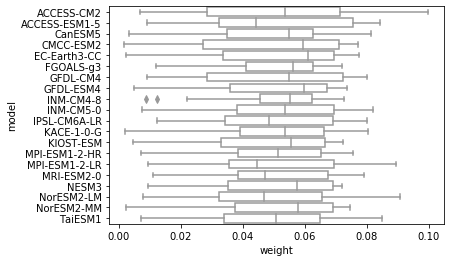

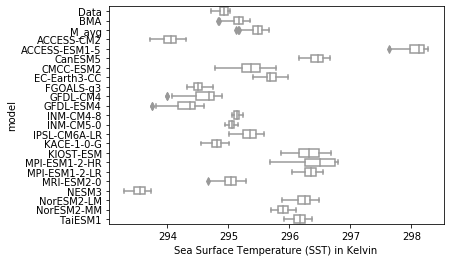

In [37]:
# Assuming you have the y_obs, y_BMA_best_1, and predictions_dict available
# Add data for plotting
y_dict = {
  'Data': y_obs,
  'BMA': y_BMA_best,
  **predictions_dict
}

# Call the function to plot prediction boxplots
plot_weights(model_names, x_posterior) # plot weights of constituent models only
plot_prediction_boxplots(y_dict,x_label= 'Sea Surface Temperature (SST) in Kelvin')

In [38]:
print(x_posterior.shape)

(499, 20)
